In [1]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [7]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/'
DATA_OUT_PATH = "data_out/"

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

# Korean Curse Classification

In [8]:
from sklearn.model_selection import train_test_split

In [40]:
# data 전처리
data_path = os.path.join(DATA_IN_PATH, "dataset.txt")

read_data = pd.read_csv(data_path, header = 0 ,delimiter = '|', error_bad_lines=False)
read_data.head()

# 읽은 데이터 8:2로 train,test 무작위로 나눔
train_data , test_data = train_test_split(read_data,
                                          test_size=0.2, 
                                          shuffle=True,
                                         random_state=1004)
# print(train_data.shape)
# print(test_data.shape)
train_data.head()

b'Skipping line 457: expected 2 fields, saw 3\n'


,document,label
754,현금으로 2000억을 가지고 있는 개인이 있댜고?,0
3905,더불어 다카끼마사오 해외계좌 찾으면 대박일텐데~,0
833,한국은 좆같은 황사가 날아오지만역살적으로 땅의 회복력이 올라감,1
812,간호사코스프레한다고 간호사비하한다고 기사나오는판에 용접공 노가다 힘들하는사람들이 웃...,0
795,에미 씹 ㅋㅋㅋㅋㅋㅋ 마인크래프트로 생각하네 인생을,1


In [41]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [52]:
# train_data = train_data[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["document"], train_data["label"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_curse_input_ids = np.array(input_ids, dtype=int)
train_curse_attention_masks = np.array(attention_masks, dtype=int)
train_curse_type_ids = np.array(token_type_ids, dtype=int)
train_curse_inputs = (train_curse_input_ids, train_curse_attention_masks, train_curse_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_curse_input_ids), len(train_data_labels)))

100%|██████████| 4659/4659 [00:01<00:00, 3176.84it/s]

# sents: 4659, # labels: 4659


In [53]:
# 최대 길이: 39
input_id = train_curse_input_ids[1]
attention_mask = train_curse_attention_masks[1]
token_type_id = train_curse_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9074 118992  12965   9056  24206 118710  23811  12945  28188
   9960  78705  21611 119215   9737  80046   9069 118963  18392 119353
  28911    198    102      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] 더불어 다카끼마사오 해외계좌 찾으면 대박일텐데 ~ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [54]:
import tensorflow as tf 

In [55]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [56]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [57]:
model_name = "tf2_bert_curse"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_curse_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

data_out/tf2_bert_curse -- Folder already exists 

Epoch 1/3
117/117 [==============================] - 701s 6s/step - loss: 0.6029 - accuracy: 0.6801 - val_loss: 0.4380 - val_accuracy: 0.8079

Epoch 00001: val_accuracy improved from -inf to 0.80794, saving model to data_out/tf2_bert_curse/weights.h5
Epoch 2/3
117/117 [==============================] - 645s 6s/step - loss: 0.4380 - accuracy: 0.8086 - val_loss: 0.3937 - val_accuracy: 0.8273

Epoch 00002: val_accuracy improved from 0.80794 to 0.82725, saving model to data_out/tf2_bert_curse/weights.h5
Epoch 3/3
117/117 [==============================] - 635s 5s/step - loss: 0.3258 - accuracy: 0.8617 - val_loss: 0.4658 - val_accuracy: 0.8026

Epoch 00003: val_accuracy did not improve from 0.82725
{'loss': [0.5589159727096558, 0.4173569679260254, 0.32313236594200134], 'accuracy': [0.7166621685028076, 0.8210356831550598, 0.8620874881744385], 'val_loss': [0.43802717328071594, 0.3936711847782135, 0.4658319056034088], 'val_accuracy': [0.807939

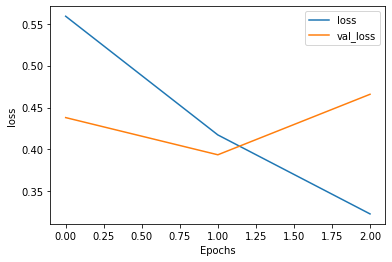

In [58]:
plot_graphs(history, 'loss')

# Korean Curse Test 데이터

In [59]:
test_data.head()

,document,label
2735,병신 니가해보든가,1
1838,저사연속 아이도 25개월이면 갓 두돌지났으니,0
4627,개독질,1
668,공산주의도 아니지 그냥 망상이지이상 (선동할때)다 같이 잘 먹고 잘 살자현실다 같이...,1
1395,이유없이 니생각대로 나보다 논리적으로 생각을 잘한다고 말한다는거 자체가 무식한거고 ...,1


In [61]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_curse_input_ids = np.array(input_ids, dtype=int)
test_curse_attention_masks = np.array(attention_masks, dtype=int)
test_curse_type_ids = np.array(token_type_ids, dtype=int)
test_curse_inputs = (test_curse_input_ids, test_curse_attention_masks, test_curse_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_curse_input_ids), len(test_data_labels)))

1165it [00:01, 724.70it/s]

num sents, labels 1165, 1165


In [63]:
results = cls_model.evaluate(test_curse_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

2/2 [==============================] - 55s 7s/step - loss: 0.4809 - accuracy: 0.7785
test loss, test acc:  [0.48085105419158936, 0.7785407900810242]


In [64]:
cls_model.load_weights('data_out/tf2_bert_curse/weights.h5')

In [84]:
cls_model.history

# predict 구현

In [238]:
predict_data = '좆됐다...씨발....'

input_ids = []
attention_masks = []
token_type_ids = []
predict_data_labels = []

input_id, attention_mask, token_type_id = bert_tokenizer(predict_data, MAX_LEN)
input_ids.append(input_id)
attention_masks.append(attention_mask)
token_type_ids.append(token_type_id)
    

predict_curse_input_ids = np.array(input_ids, dtype=int)
predict_curse_attention_masks = np.array(attention_masks, dtype=int)
predict_curse_type_ids = np.array(token_type_ids, dtype=int)
predict_curse_inputs = (predict_curse_input_ids, predict_curse_attention_masks, predict_curse_type_ids)

# predict_data_labels = np.asarray(predict_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

# print(input_id)
# print(attention_mask)
# print(token_type_id)
print(tokenizer.decode(input_id))

# print(predict_curse_input_ids)
# print(predict_curse_attention_masks)
# print(predict_curse_type_ids)
# print(predict_curse_inputs)

[CLS] [UNK]... 씨발.... [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [240]:
result = cls_model.predict(predict_curse_inputs[0])
print('욕인 확률은?', result[0][1]*100)

욕인 확률은? 99.13040399551392
